In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import pymc.sampling_jax
import scipy.stats as stats
import seaborn as sns
import arviz as az
import xarray as xr
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

In [3]:
def generate():
    group_list = ["one", "two", "three", "four", "five"]
    trials_per_group = 20
    group_intercepts = rng.normal(0, 1, len(group_list))
    group_slopes = np.ones(len(group_list)) * -0.5
    group_mx = group_intercepts * 2
    group = np.repeat(group_list, trials_per_group)
    subject = np.concatenate(
        [np.ones(trials_per_group) * i for i in np.arange(len(group_list))]
    ).astype(int)
    intercept = np.repeat(group_intercepts, trials_per_group)
    slope = np.repeat(group_slopes, trials_per_group)
    mx = np.repeat(group_mx, trials_per_group)
    x = rng.normal(mx, 1)
    y = rng.normal(intercept + (x - mx) * slope, 1)
    data = pd.DataFrame({"group": group, "group_idx": subject, "x": x, "y": y})
    return data, group_list

In [4]:
data, group_list = generate()

In [5]:
print(group_list)

['one', 'two', 'three', 'four', 'five']


In [6]:
display(data)

,group,group_idx,x,y
0,one,0,-0.692745,0.750369
1,one,0,0.737275,-0.709225
2,one,0,0.293192,0.123805
3,one,0,0.592633,1.153426
4,one,0,-0.243610,-0.996081
...,...,...,...,...
95,five,4,-4.280233,-1.424379
96,five,4,-2.602842,-1.193167
97,five,4,-4.258334,-1.682318
98,five,4,-3.164555,-1.675854


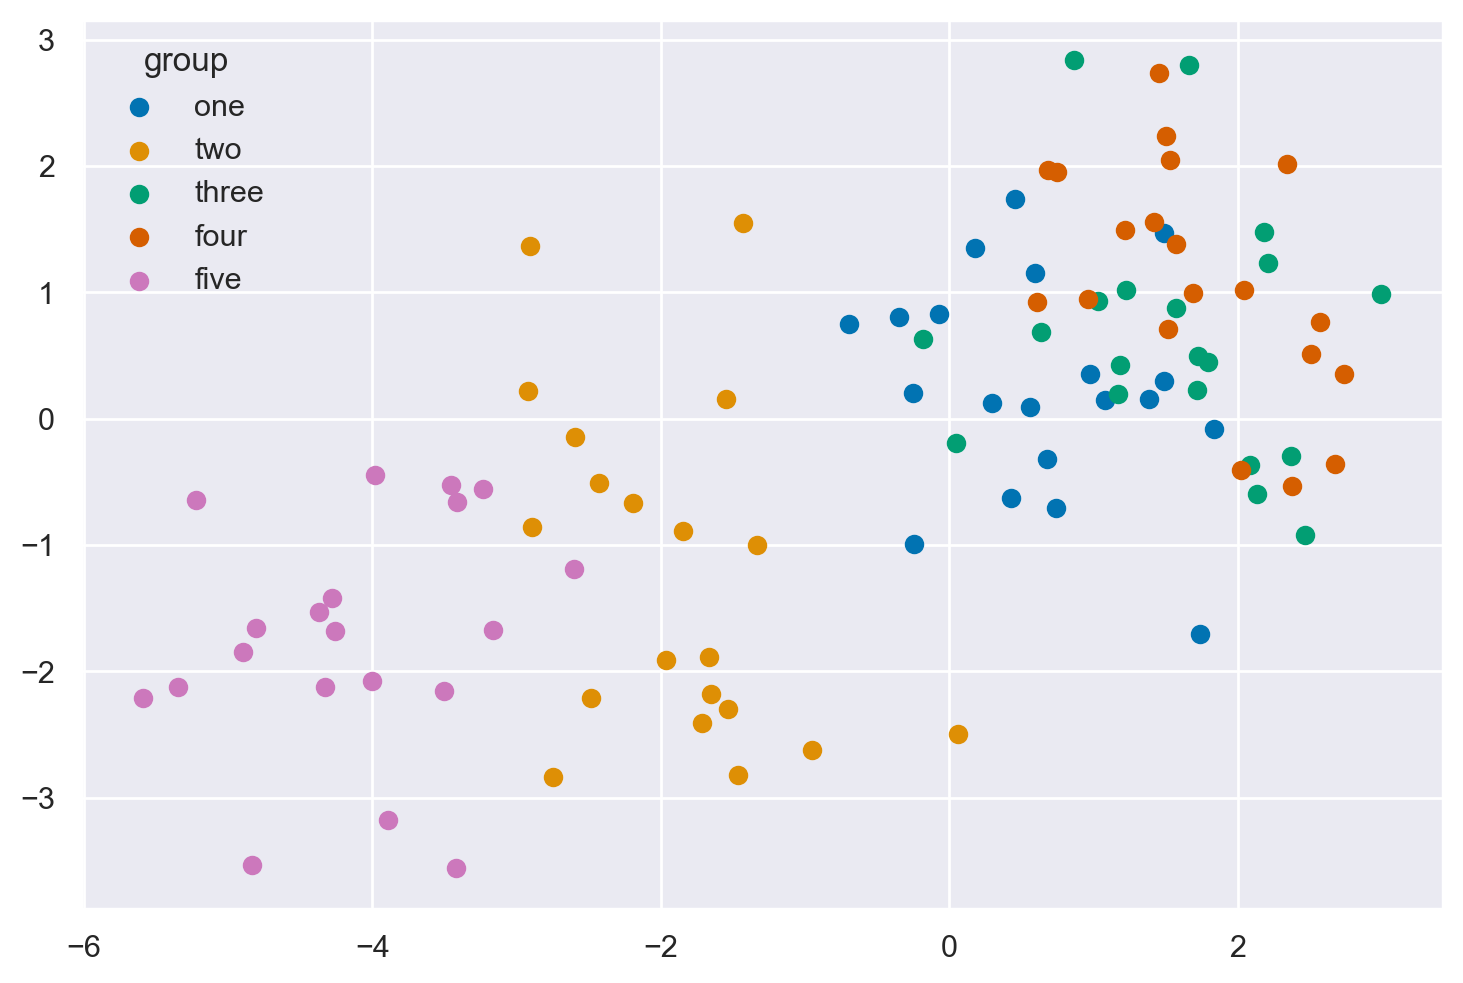

In [7]:
for i, group in enumerate(group_list):
    plt.scatter(
        data.x[data.group_idx == i],
        data.y[data.group_idx == i],
        color=f"C{i}",
        label=f"{group}",
    )
plt.legend(title="group");

In [8]:
with pm.Model() as linear_regression:
    sigma = pm.HalfCauchy("sigma", beta=2)
    β0 = pm.Normal("β0", 0, sigma=5)
    β1 = pm.Normal("β1", 0, sigma=5)
    x = pm.MutableData("x", data.x, dims="obs_id")
    μ = pm.Deterministic("μ", β0 + β1 * x, dims="obs_id")
    pm.Normal("y", mu=μ, sigma=sigma, observed=data.y, dims="obs_id")

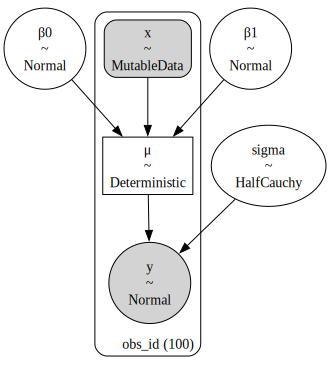

In [9]:
pm.model_to_graphviz(linear_regression)

In [10]:
with linear_regression:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time = 0:00:01.564034


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:02<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:02<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:02<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:02<?, ?it/s]

Running chain 0: 100%|█████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 869.67it/s]


Running chain 1: 100%|█████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 870.08it/s]


Running chain 2: 100%|█████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 870.79it/s]


Running chain 3: 100%|█████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 871.48it/s]


Sampling time = 0:00:02.672838


Transforming variables...


Transformation time = 0:00:00.170641


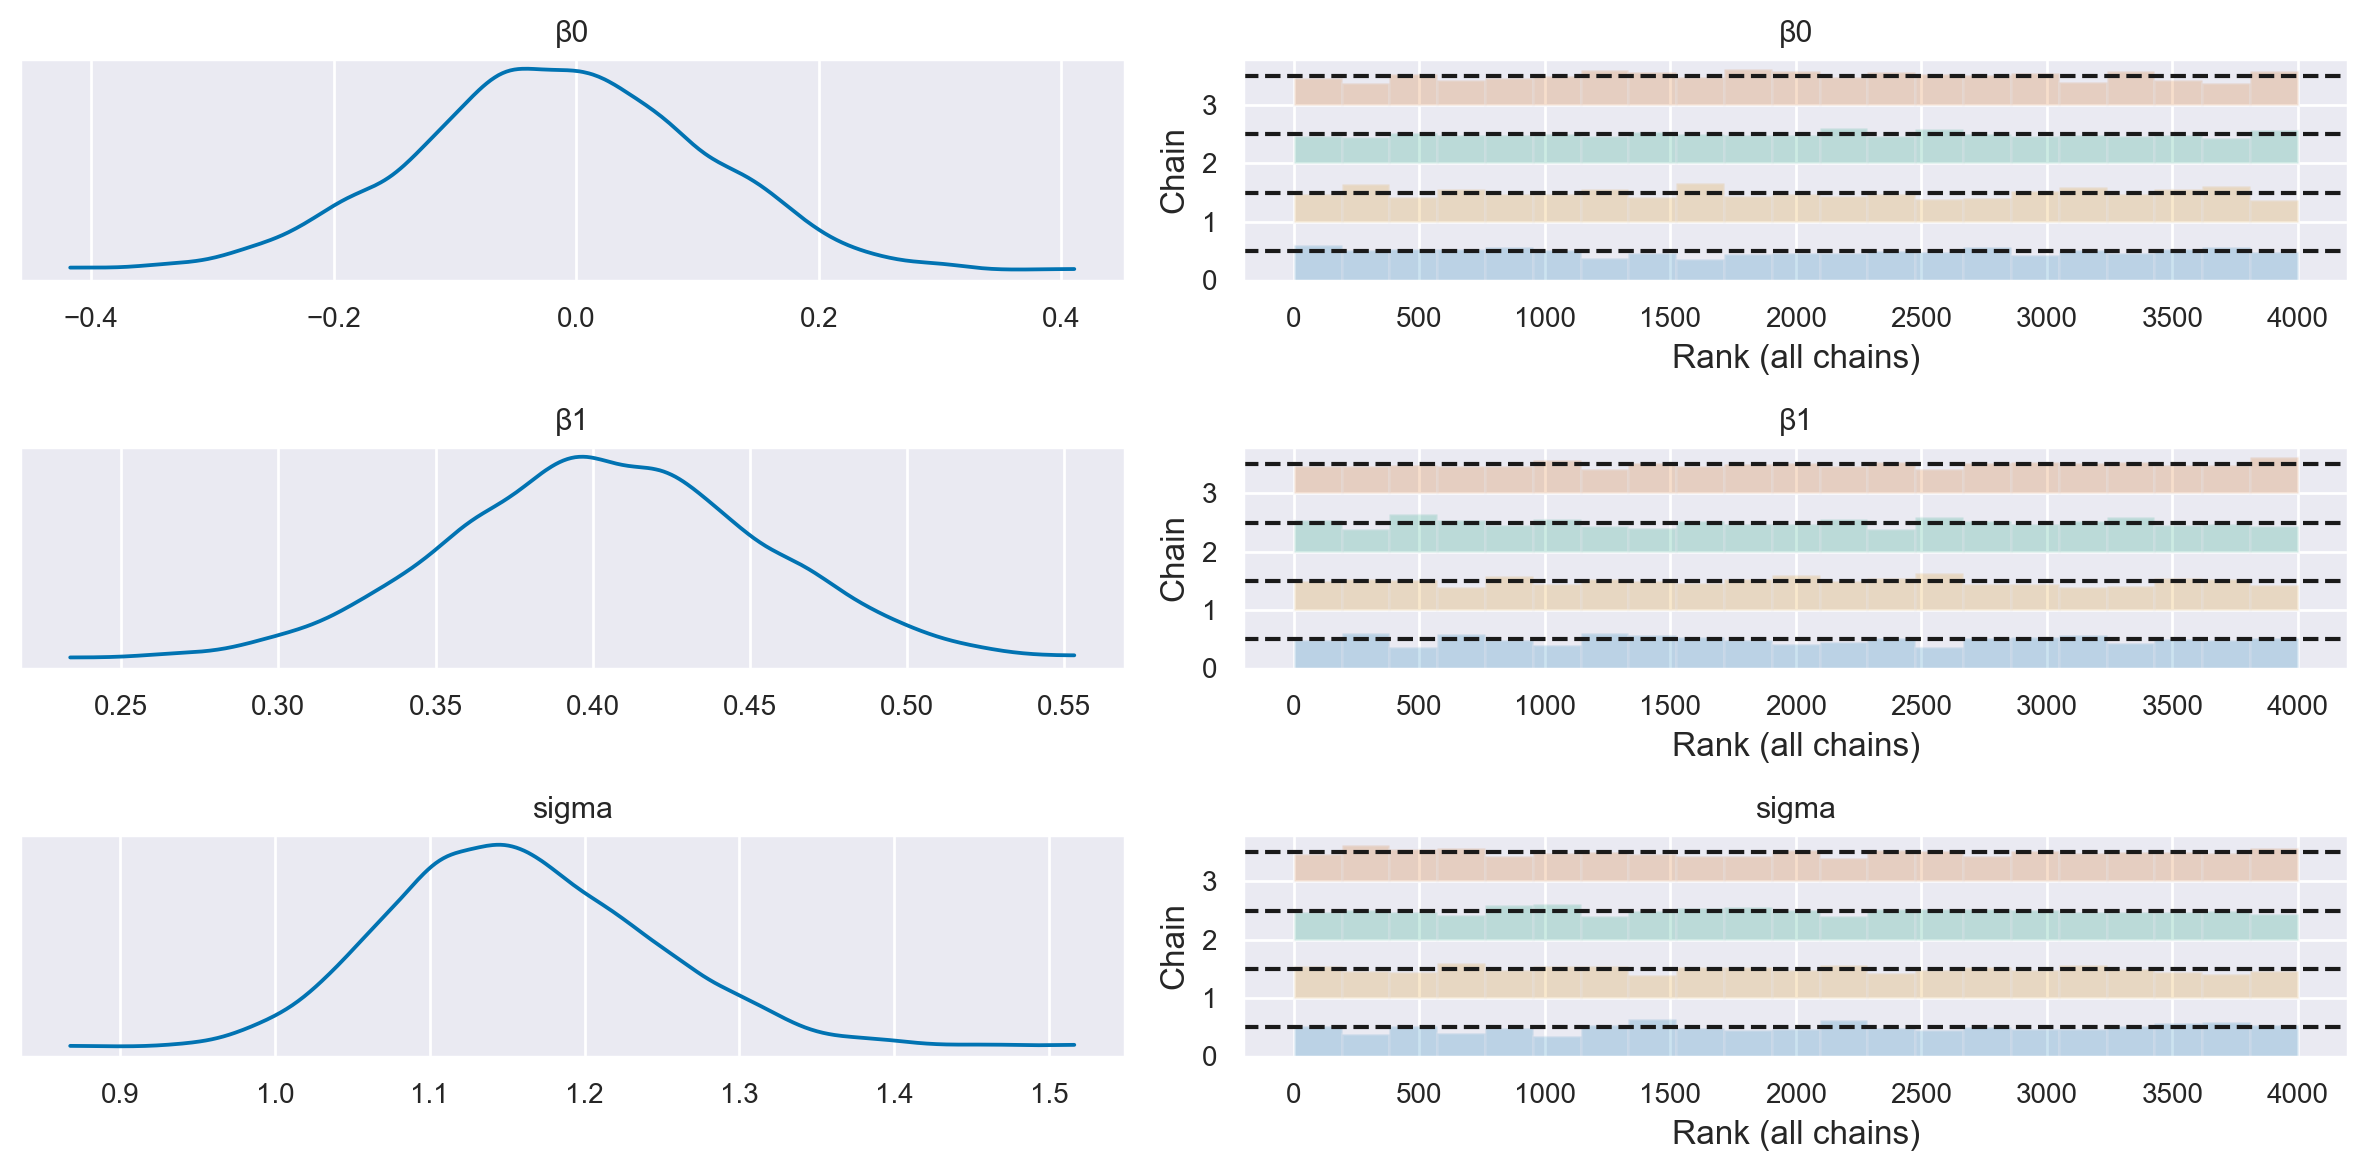

In [11]:
az.plot_trace(
    idata,
    filter_vars="regex",
    var_names=["~μ"],
    kind="rank_bars",
    combined=True,
    divergences="bottom",
)
plt.tight_layout()

In [12]:
# posterior prediction for these x values
xi = np.linspace(data.x.min(), data.x.max(), 20)

# do posterior predictive inference
with linear_regression:
    pm.set_data({"x": xi})
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["y", "μ"]))

Sampling: [y]


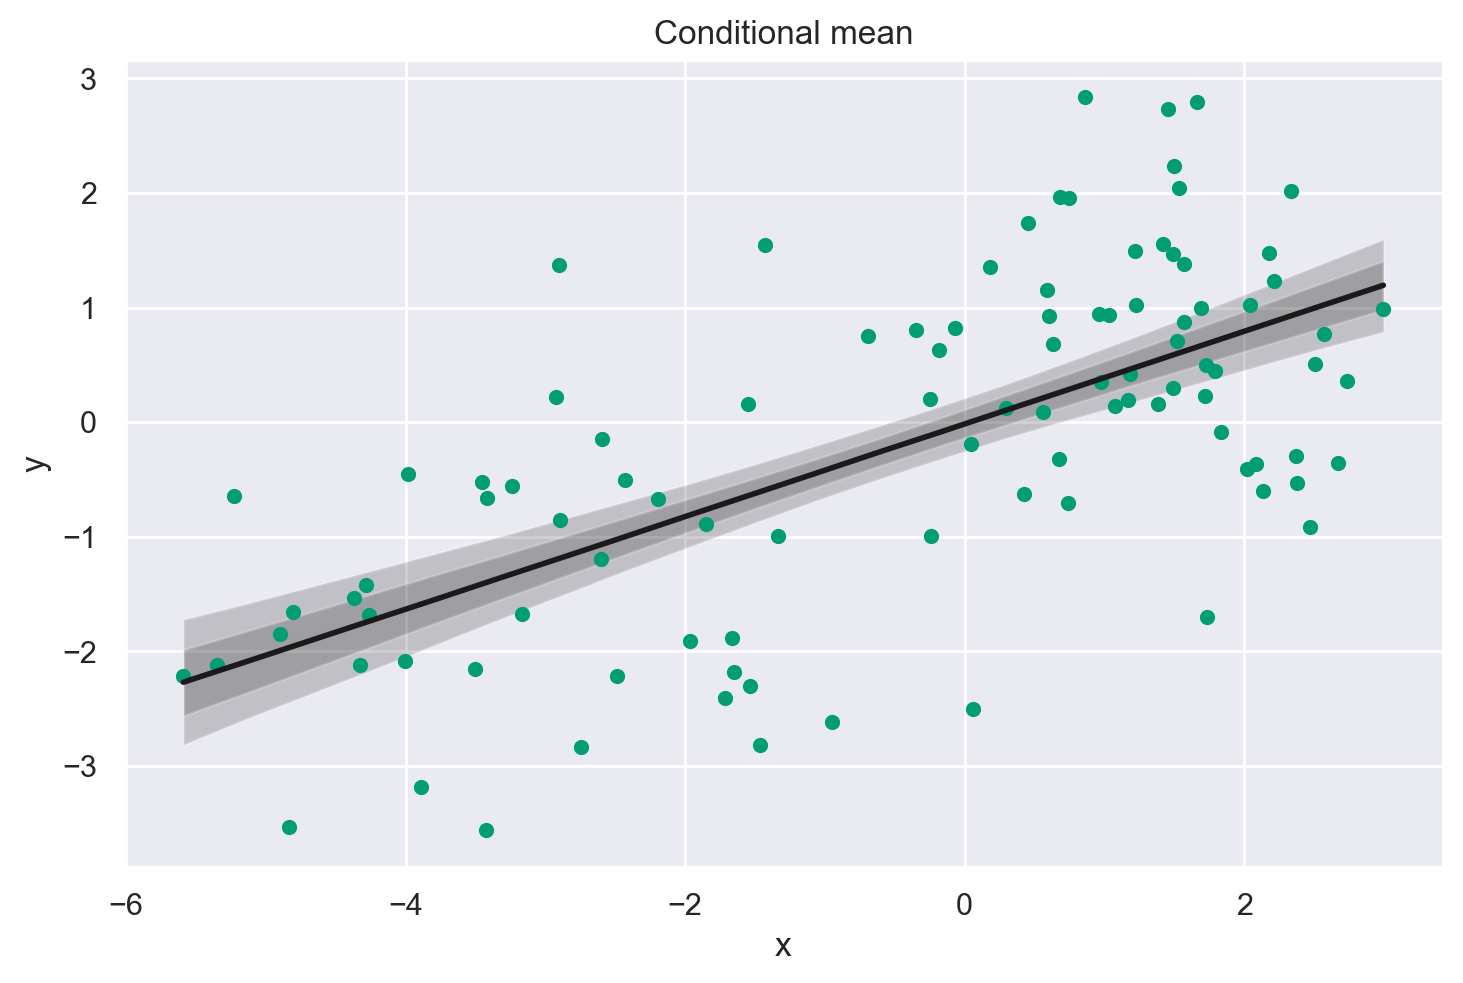

In [13]:
post = az.extract(idata)

xi = xr.DataArray(np.linspace(np.min(data['x']), np.max(data['x']), 20), dims=["x_plot"])
y = post.β0 + post.β1 * xi
region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")

fig, ax = plt.subplots(1, 1)

ax.fill_between(
    xi, region.sel(quantile=0.025), region.sel(quantile=0.975), alpha=0.2, color="k", edgecolor="w"
)
ax.fill_between(
    xi, region.sel(quantile=0.15), region.sel(quantile=0.85), alpha=0.2, color="k", edgecolor="w"
)

# Plotting the conditional mean
ax.plot(xi, region.sel(quantile=0.5), "k", linewidth=2)

# Plotting the data points
ax.scatter(data['x'], data['y'], color='C2', s=20, label='Data points')

# Formatting
ax.set(xlabel="x", ylabel="y", title="Conditional mean")

plt.show()  # Add this line to actually show the plot

In [14]:
beta_0 = idata.posterior.β0.mean().values
print(beta_0)

-0.01663299231684704


In [15]:
beta_1 = idata.posterior.β1.mean().values
print(beta_1)

0.4040968623679126


In [16]:
xi = np.linspace(np.min(data["x"]), np.max(data["x"]), 20)
xi

array([-5.58940481, -5.13754963, -4.68569444, -4.23383926, -3.78198407,
       -3.33012889, -2.8782737 , -2.42641852, -1.97456333, -1.52270815,
       -1.07085296, -0.61899778, -0.16714259,  0.28471259,  0.73656778,
        1.18842296,  1.64027815,  2.09213333,  2.54398852,  2.9958437 ])

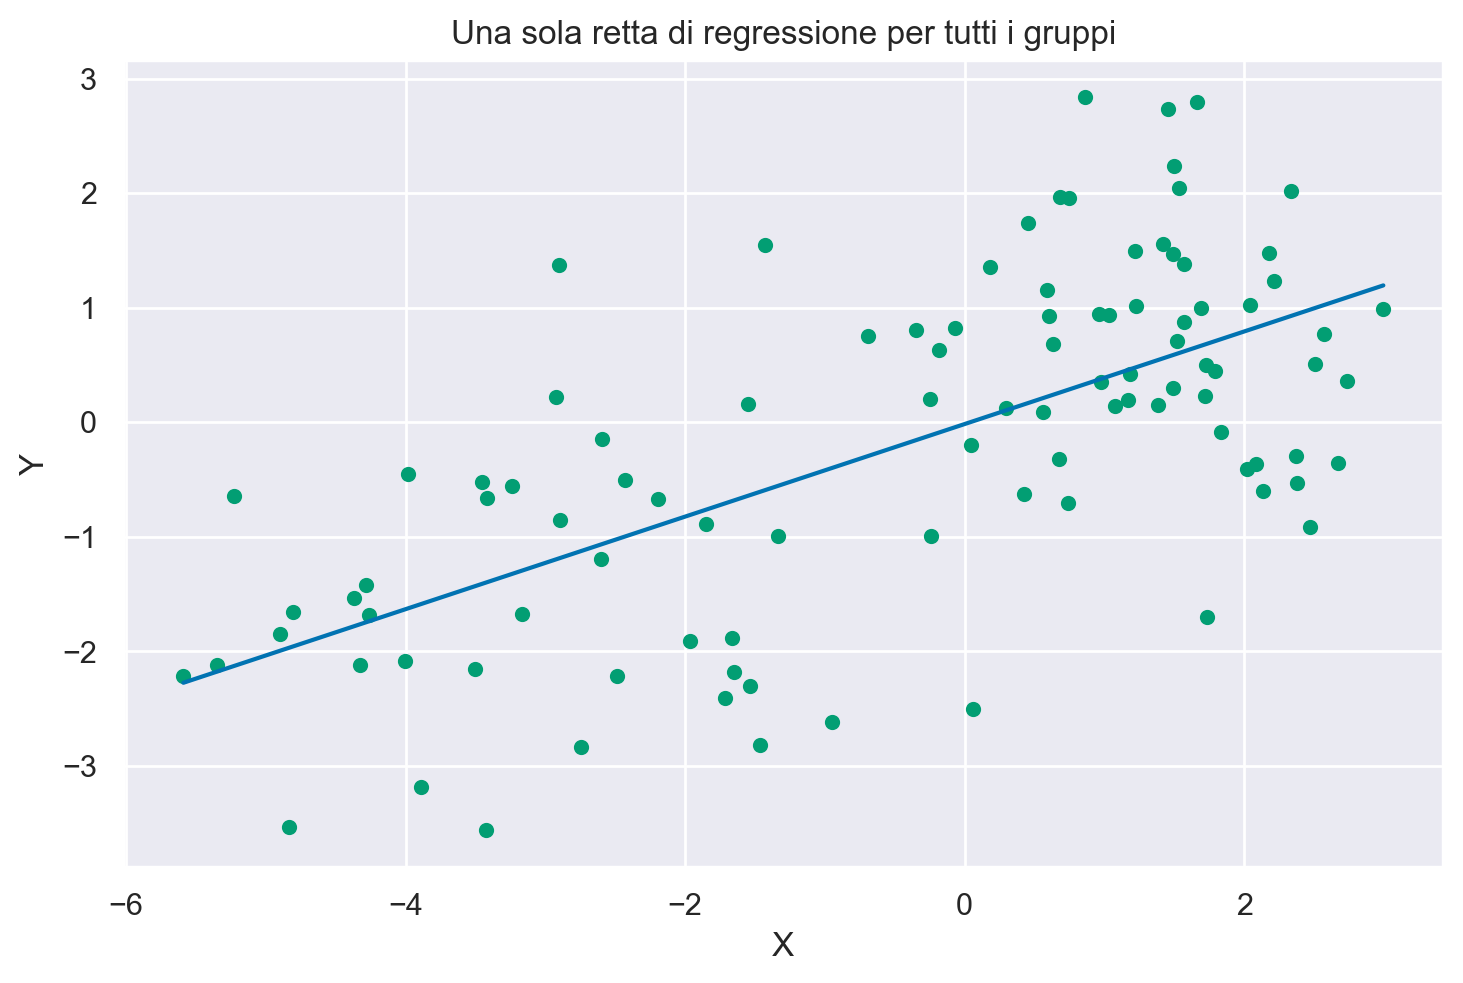

In [17]:
# Genera la linea di regressione utilizzando l'equazione della retta
y_pred = beta_0 + beta_1 * xi

# Visualizza la linea di regressione
plt.plot(xi, y_pred)
plt.scatter(data['x'], data['y'], color='C2', s=20)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Una sola retta di regressione per tutti i gruppi')
plt.show()

In [18]:
az.summary(idata, var_names="β1")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β1,0.404,0.049,0.312,0.496,0.001,0.001,3145.0,2722.0,1.0


In [19]:
coords = {"group": group_list}

with pm.Model(coords=coords) as ind_slope_intercept:
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=2, dims="group")
    β0 = pm.Normal("β0", 0, sigma=5, dims="group")
    β1 = pm.Normal("β1", 0, sigma=5, dims="group")
    # Data
    x = pm.MutableData("x", data.x, dims="obs_id")
    g = pm.MutableData("g", data.group_idx, dims="obs_id")
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="obs_id")

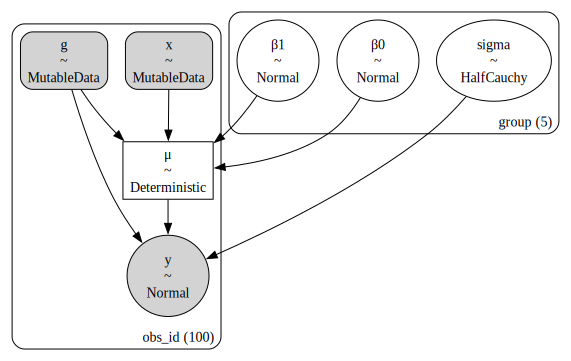

In [20]:
pm.model_to_graphviz(ind_slope_intercept)

In [21]:
with ind_slope_intercept:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time = 0:00:01.231752


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:02<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:02<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:02<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:02<?, ?it/s]

Running chain 1:  30%|███████████████▉                                     | 600/2000 [00:02<00:00, 5956.80it/s]

Running chain 2:  30%|███████████████▉                                     | 600/2000 [00:02<00:00, 5910.93it/s]

Running chain 0:  30%|███████████████▉                                     | 600/2000 [00:02<00:00, 5518.55it/s]

Running chain 3:  35%|██████████████████▌                                  | 700/2000 [00:02<00:00, 6259.67it/s]

Running chain 2:  70%|████████████████████████████████████▍               | 1400/2000 [00:02<00:00, 6960.57it/s]

Running chain 1:  70%|████████████████████████████████████▍               | 1400/2000 [00:02<00:00, 6839.19it/s]

Running chain 3:  75%|███████████████████████████████████████             | 1500/2000 [00:02<00:00, 7029.25it/s]

Running chain 0:  75%|███████████████████████████████████████             | 1500/2000 [00:02<00:00, 7019.05it/s]

Running chain 0: 100%|█████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 677.32it/s]


Running chain 1: 100%|█████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 677.61it/s]


Running chain 2: 100%|█████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 678.01it/s]


Running chain 3: 100%|█████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 678.37it/s]

Sampling time = 0:00:03.111960


Transforming variables...


Transformation time = 0:00:00.153296


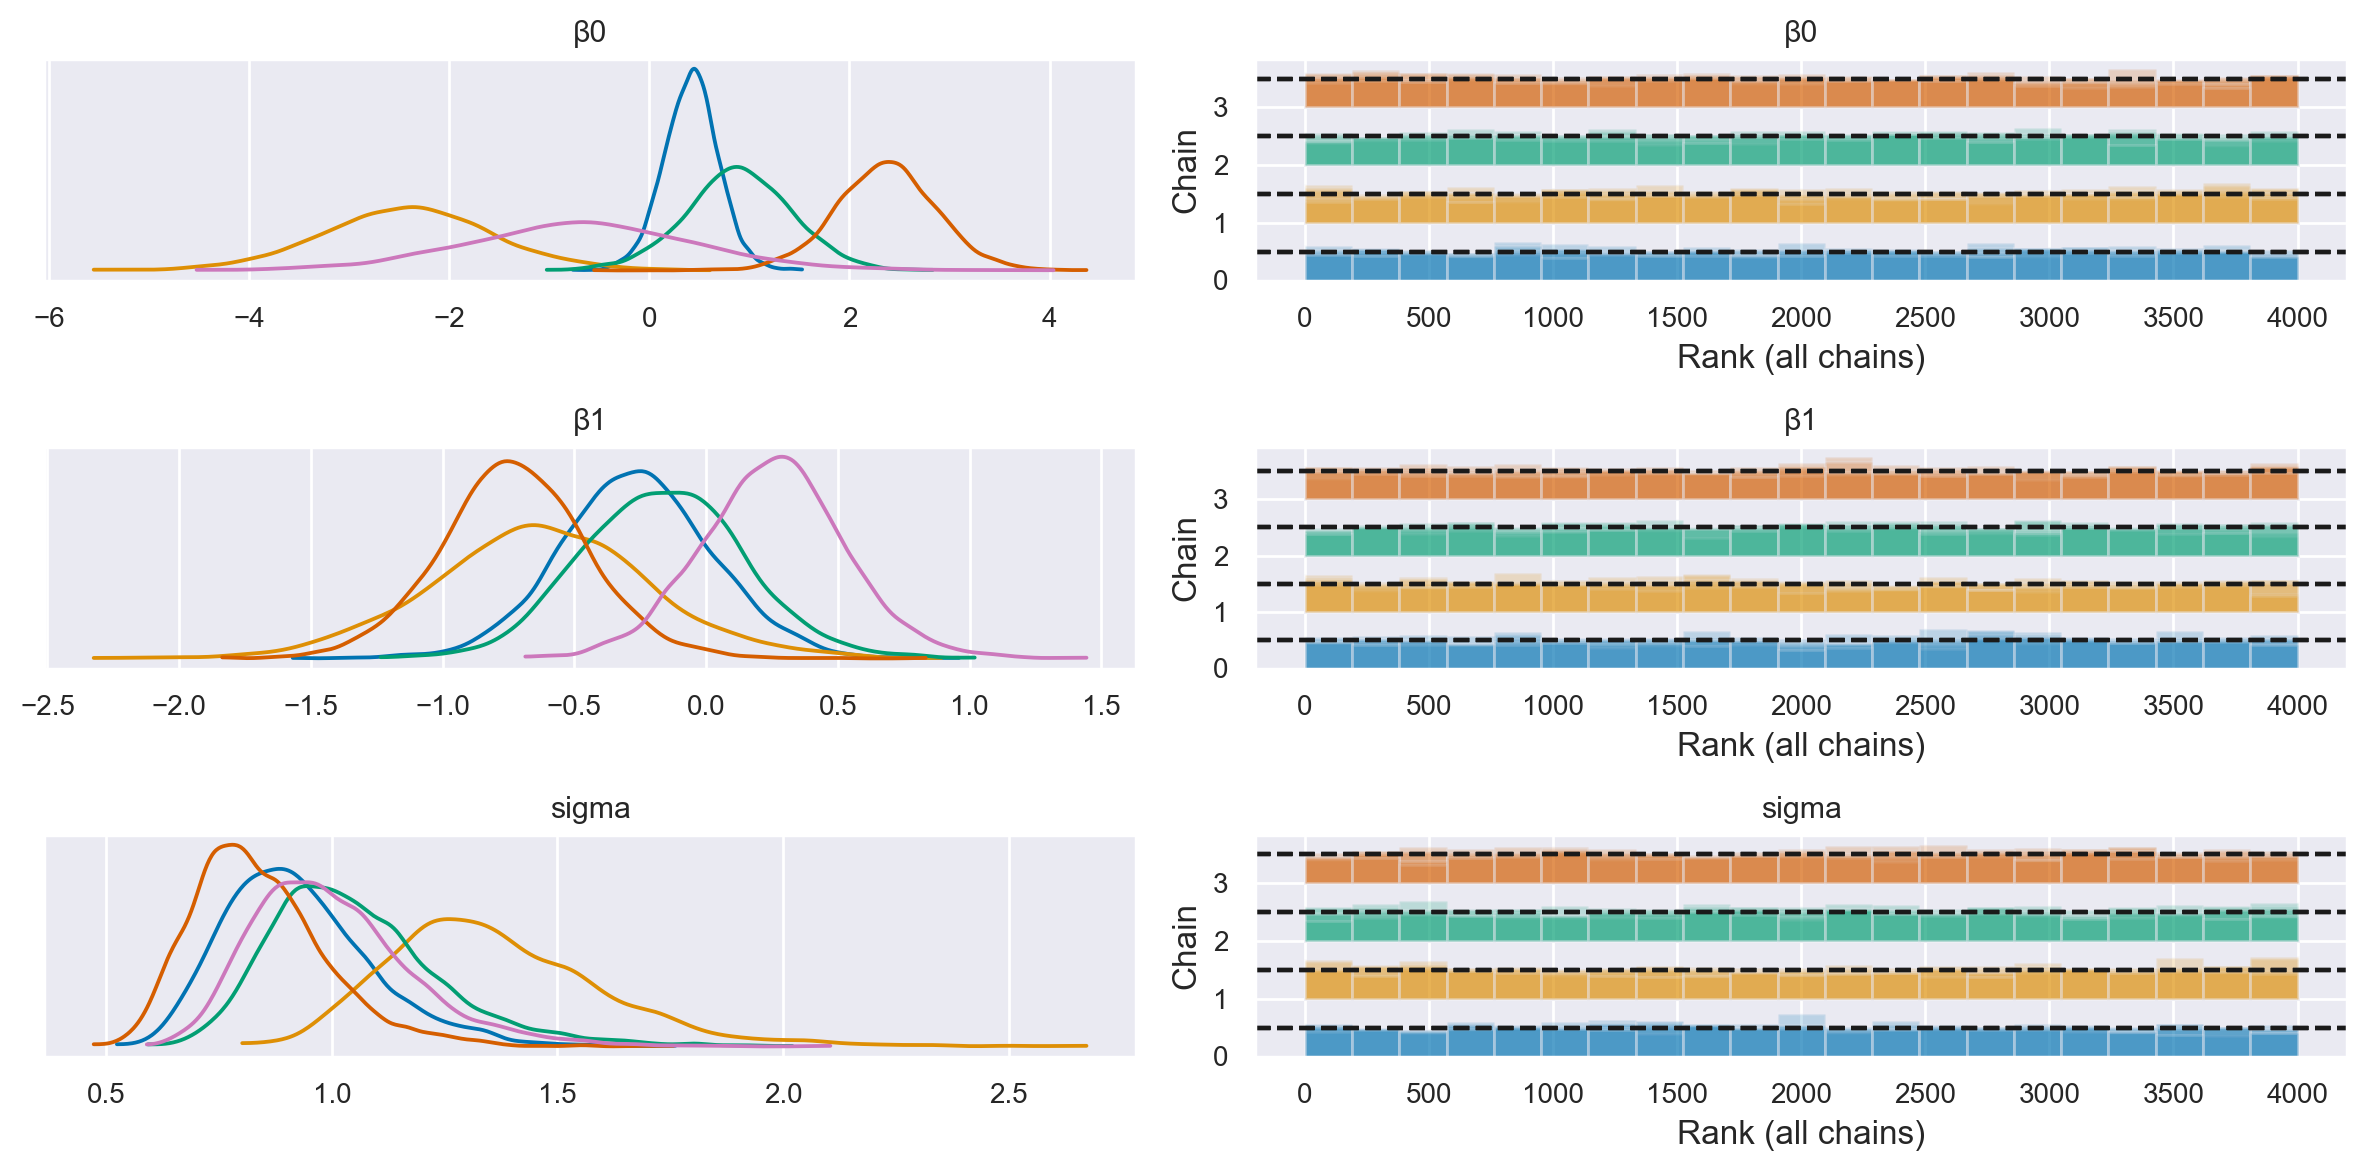

In [22]:
az.plot_trace(
    idata,
    combined=True,
    filter_vars="regex",
    var_names=["~μ"],
    kind="rank_bars",
    divergences="bottom",
)
plt.tight_layout()

In [23]:
# Create values of x and g to use for posterior prediction
xi = [
    np.linspace(data.query(f"group_idx=={i}").x.min(), data.query(f"group_idx=={i}").x.max(), 10)
    for i, _ in enumerate(group_list)
]
g = [np.ones(10) * i for i, _ in enumerate(group_list)]
xi, g = np.concatenate(xi), np.concatenate(g)

# Do the posterior prediction
with ind_slope_intercept:
    pm.set_data({"x": xi, "g": g.astype(int)})
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["μ", "y"]))

Sampling: [y]


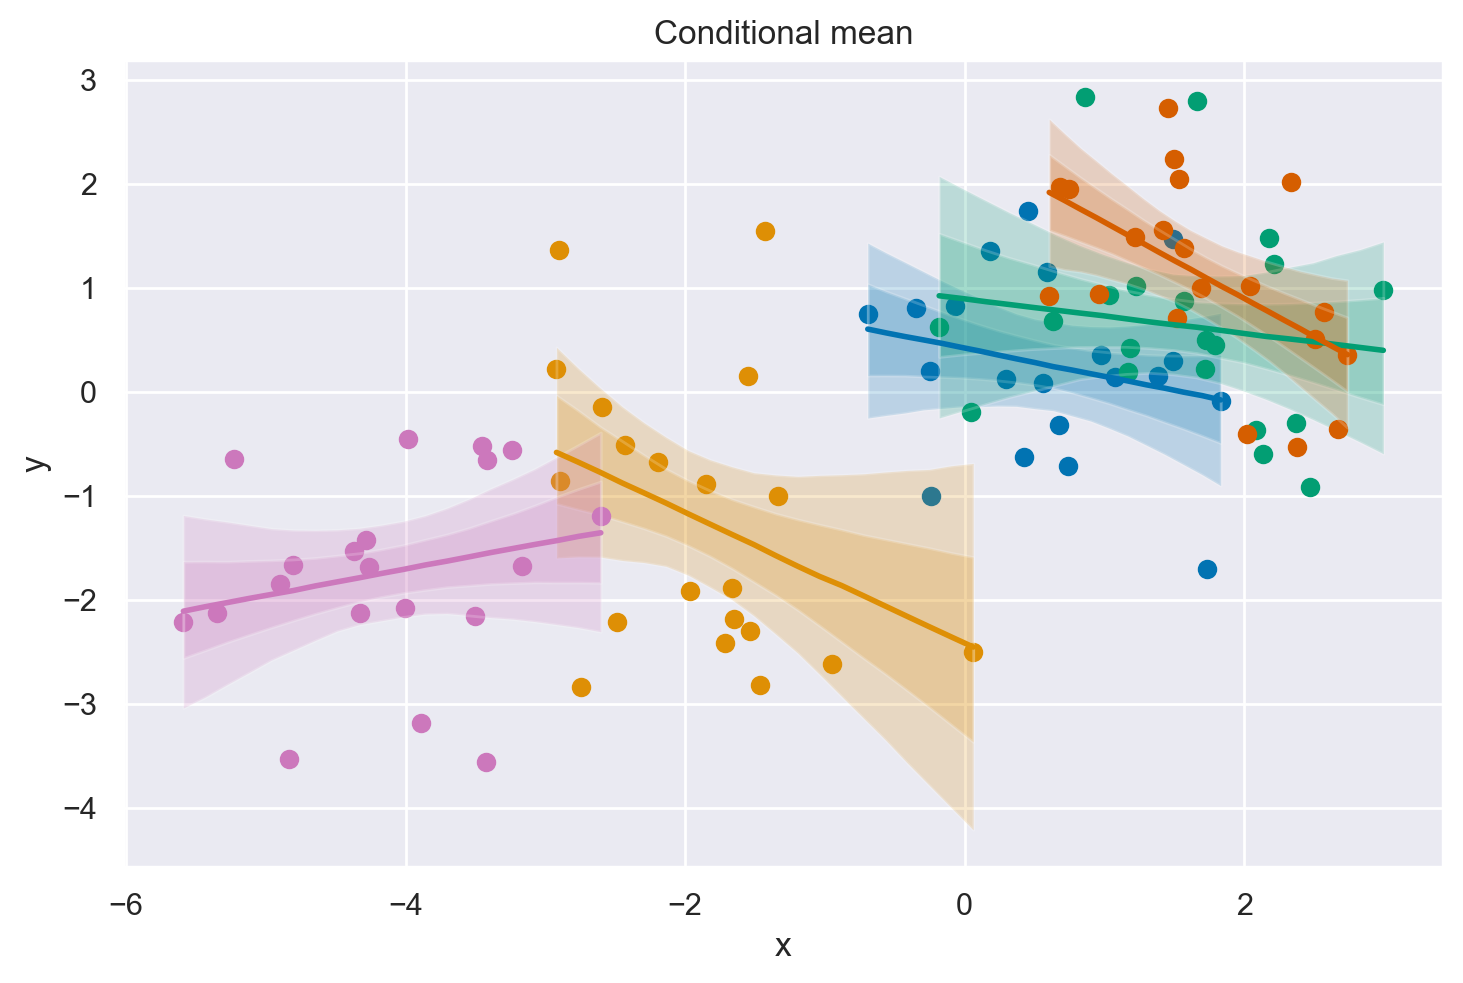

In [24]:
def get_ppy_for_group(group_list, group):
    """Get posterior predictive outcomes for observations from a given group"""
    return idata.posterior_predictive.y.data[:, :, group_list == group]


fig, ax = plt.subplots(1, 1)

# conditional mean plot ---------------------------------------------
for i, groupname in enumerate(group_list):
    # data
    ax.scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
    # conditional mean credible intervals
    post = az.extract(idata)
    _xi = xr.DataArray(
        np.linspace(np.min(data.x[data.group_idx == i]), np.max(data.x[data.group_idx == i]), 20),
        dims=["x_plot"],
    )
    y = post.β0.sel(group=groupname) + post.β1.sel(group=groupname) * _xi
    region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
    ax.fill_between(
        _xi,
        region.sel(quantile=0.025),
        region.sel(quantile=0.975),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    ax.fill_between(
        _xi,
        region.sel(quantile=0.15),
        region.sel(quantile=0.85),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    # conditional mean
    ax.plot(_xi, region.sel(quantile=0.5), color=f"C{i}", linewidth=2)
    # formatting
    ax.set(xlabel="x", ylabel="y", title="Conditional mean")


In [25]:
non_centered = False

with pm.Model(coords=coords) as hierarchical:
    # Hyperpriors
    intercept_mu = pm.Normal("intercept_mu", 0, sigma=1)
    intercept_sigma = pm.HalfNormal("intercept_sigma", sigma=2)
    slope_mu = pm.Normal("slope_mu", 0, sigma=1)
    slope_sigma = pm.HalfNormal("slope_sigma", sigma=2)
    sigma_hyperprior = pm.HalfNormal("sigma_hyperprior", sigma=0.5)

    # Define priors
    sigma = pm.HalfNormal("sigma", sigma=sigma_hyperprior, dims="group")

    if non_centered:
        β0_offset = pm.Normal("β0_offset", 0, sigma=1, dims="group")
        β0 = pm.Deterministic("β0", intercept_mu + β0_offset * intercept_sigma, dims="group")
        β1_offset = pm.Normal("β1_offset", 0, sigma=1, dims="group")
        β1 = pm.Deterministic("β1", slope_mu + β1_offset * slope_sigma, dims="group")
    else:
        β0 = pm.Normal("β0", intercept_mu, sigma=intercept_sigma, dims="group")
        β1 = pm.Normal("β1", slope_mu, sigma=slope_sigma, dims="group")

    # Data
    x = pm.MutableData("x", data.x, dims="obs_id")
    g = pm.MutableData("g", data.group_idx, dims="obs_id")
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="obs_id")

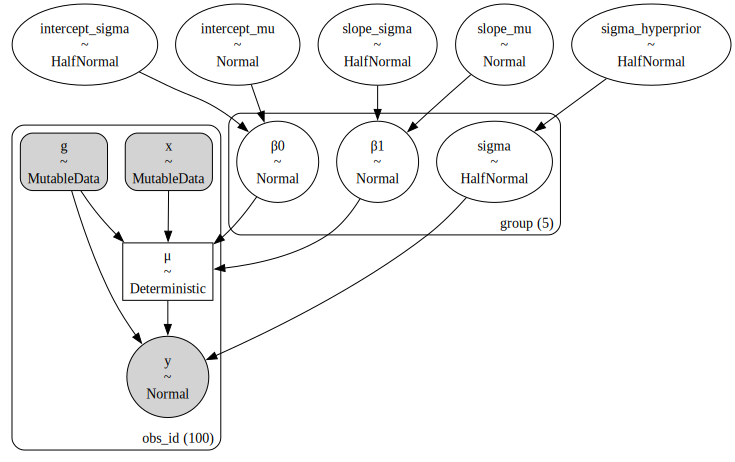

In [26]:
pm.model_to_graphviz(hierarchical)

In [27]:
with hierarchical:
    idata = pm.sampling_jax.sample_numpyro_nuts(tune=5000, target_accept=0.99)

Compiling...


Compilation time = 0:00:01.780467


Sampling...


  0%|                                                                                  | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/6000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/6000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/6000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/6000 [00:00<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/6000 [00:03<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/6000 [00:03<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/6000 [00:03<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/6000 [00:03<?, ?it/s]

Running chain 3:   5%|██▋                                                  | 300/6000 [00:03<00:03, 1858.26it/s]

Running chain 1:   5%|██▋                                                  | 300/6000 [00:03<00:03, 1729.40it/s]

Running chain 2:   5%|██▋                                                  | 300/6000 [00:03<00:03, 1604.30it/s]

Running chain 0:   5%|██▋                                                  | 300/6000 [00:03<00:03, 1560.87it/s]

Running chain 2:  10%|█████▎                                               | 600/6000 [00:03<00:02, 2126.84it/s]

Running chain 0:  10%|█████▎                                               | 600/6000 [00:03<00:02, 2132.96it/s]

Running chain 1:  10%|█████▎                                               | 600/6000 [00:03<00:02, 2024.51it/s]

Running chain 3:  10%|█████▎                                               | 600/6000 [00:03<00:03, 1785.80it/s]

Running chain 2:  15%|███████▉                                             | 900/6000 [00:03<00:02, 2288.82it/s]

Running chain 0:  15%|███████▉                                             | 900/6000 [00:03<00:02, 2276.98it/s]

Running chain 3:  15%|███████▉                                             | 900/6000 [00:03<00:02, 2124.57it/s]

Running chain 1:  15%|███████▉                                             | 900/6000 [00:03<00:02, 1952.04it/s]

Running chain 2:  20%|██████████▍                                         | 1200/6000 [00:04<00:01, 2503.72it/s]

Running chain 0:  20%|██████████▍                                         | 1200/6000 [00:04<00:01, 2458.33it/s]

Running chain 2:  25%|█████████████                                       | 1500/6000 [00:04<00:01, 2627.16it/s]

Running chain 3:  25%|█████████████                                       | 1500/6000 [00:04<00:01, 2541.54it/s]

Running chain 1:  20%|██████████▍                                         | 1200/6000 [00:04<00:03, 1489.10it/s]

Running chain 2:  30%|███████████████▌                                    | 1800/6000 [00:04<00:01, 2525.59it/s]

Running chain 3:  30%|███████████████▌                                    | 1800/6000 [00:04<00:01, 2562.76it/s]

Running chain 1:  25%|█████████████                                       | 1500/6000 [00:04<00:02, 1725.16it/s]

Running chain 0:  30%|███████████████▌                                    | 1800/6000 [00:04<00:02, 1868.97it/s]

Running chain 2:  40%|████████████████████▊                               | 2400/6000 [00:04<00:01, 2817.66it/s]

Running chain 3:  40%|████████████████████▊                               | 2400/6000 [00:04<00:01, 2833.33it/s]

Running chain 1:  30%|███████████████▌                                    | 1800/6000 [00:04<00:02, 1868.22it/s]

Running chain 0:  35%|██████████████████▏                                 | 2100/6000 [00:04<00:01, 2038.50it/s]

Running chain 2:  45%|███████████████████████▍                            | 2700/6000 [00:04<00:01, 2645.69it/s]

Running chain 0:  40%|████████████████████▊                               | 2400/6000 [00:04<00:01, 2237.58it/s]

Running chain 1:  35%|██████████████████▏                                 | 2100/6000 [00:04<00:02, 1846.56it/s]

Running chain 3:  50%|██████████████████████████                          | 3000/6000 [00:04<00:01, 2672.98it/s]

Running chain 2:  50%|██████████████████████████                          | 3000/6000 [00:04<00:01, 2599.99it/s]

Running chain 0:  45%|███████████████████████▍                            | 2700/6000 [00:04<00:01, 2325.87it/s]

Running chain 1:  40%|████████████████████▊                               | 2400/6000 [00:04<00:01, 2037.44it/s]

Running chain 2:  55%|████████████████████████████▌                       | 3300/6000 [00:04<00:01, 2476.32it/s]

Running chain 3:  55%|████████████████████████████▌                       | 3300/6000 [00:04<00:01, 2441.10it/s]

Running chain 0:  50%|██████████████████████████                          | 3000/6000 [00:04<00:01, 2403.98it/s]

Running chain 1:  45%|███████████████████████▍                            | 2700/6000 [00:04<00:01, 2193.69it/s]

Running chain 2:  60%|███████████████████████████████▏                    | 3600/6000 [00:04<00:00, 2504.90it/s]

Running chain 3:  60%|███████████████████████████████▏                    | 3600/6000 [00:05<00:01, 2377.19it/s]

Running chain 0:  55%|████████████████████████████▌                       | 3300/6000 [00:05<00:01, 2309.65it/s]

Running chain 2:  65%|█████████████████████████████████▊                  | 3900/6000 [00:05<00:00, 2630.26it/s]

Running chain 1:  50%|██████████████████████████                          | 3000/6000 [00:05<00:01, 2085.46it/s]

Running chain 3:  65%|█████████████████████████████████▊                  | 3900/6000 [00:05<00:00, 2478.24it/s]

Running chain 0:  60%|███████████████████████████████▏                    | 3600/6000 [00:05<00:01, 2322.01it/s]

Running chain 2:  70%|████████████████████████████████████▍               | 4200/6000 [00:05<00:00, 2625.89it/s]

Running chain 1:  55%|████████████████████████████▌                       | 3300/6000 [00:05<00:01, 2051.93it/s]

Running chain 0:  65%|█████████████████████████████████▊                  | 3900/6000 [00:05<00:00, 2376.16it/s]

Running chain 2:  75%|███████████████████████████████████████             | 4500/6000 [00:05<00:00, 2332.67it/s]

Running chain 3:  75%|███████████████████████████████████████             | 4500/6000 [00:05<00:00, 2389.78it/s]

Running chain 0:  70%|████████████████████████████████████▍               | 4200/6000 [00:05<00:00, 2381.33it/s]

Running chain 1:  65%|█████████████████████████████████▊                  | 3900/6000 [00:05<00:00, 2323.90it/s]

Running chain 2:  80%|█████████████████████████████████████████▌          | 4800/6000 [00:05<00:00, 2423.43it/s]

Running chain 3:  80%|█████████████████████████████████████████▌          | 4800/6000 [00:05<00:00, 2379.96it/s]

Running chain 0:  75%|███████████████████████████████████████             | 4500/6000 [00:05<00:00, 2381.28it/s]

Running chain 1:  70%|████████████████████████████████████▍               | 4200/6000 [00:05<00:00, 2393.39it/s]

Running chain 3:  85%|████████████████████████████████████████████▏       | 5100/6000 [00:05<00:00, 2418.08it/s]

Running chain 2:  85%|████████████████████████████████████████████▏       | 5100/6000 [00:05<00:00, 2087.25it/s]

Running chain 0:  80%|█████████████████████████████████████████▌          | 4800/6000 [00:05<00:00, 2315.08it/s]

Running chain 1:  75%|███████████████████████████████████████             | 4500/6000 [00:05<00:00, 2496.11it/s]

Running chain 3:  90%|██████████████████████████████████████████████▊     | 5400/6000 [00:05<00:00, 2495.06it/s]

Running chain 1:  80%|█████████████████████████████████████████▌          | 4800/6000 [00:05<00:00, 2556.83it/s]

Running chain 0:  85%|████████████████████████████████████████████▏       | 5100/6000 [00:05<00:00, 2310.17it/s]

Running chain 3:  95%|█████████████████████████████████████████████████▍  | 5700/6000 [00:05<00:00, 2572.25it/s]

Running chain 2:  90%|██████████████████████████████████████████████▊     | 5400/6000 [00:05<00:00, 1671.24it/s]

Running chain 1:  85%|████████████████████████████████████████████▏       | 5100/6000 [00:05<00:00, 2413.29it/s]

Running chain 3: 100%|████████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 2592.35it/s]

Running chain 0:  95%|█████████████████████████████████████████████████▍  | 5700/6000 [00:05<00:00, 2631.03it/s]

Running chain 1:  90%|██████████████████████████████████████████████▊     | 5400/6000 [00:06<00:00, 2422.49it/s]

Running chain 1:  95%|█████████████████████████████████████████████████▍  | 5700/6000 [00:06<00:00, 2426.85it/s]

Running chain 2:  95%|█████████████████████████████████████████████████▍  | 5700/6000 [00:06<00:00, 1454.74it/s]

Running chain 1: 100%|████████████████████████████████████████████████████| 6000/6000 [00:06<00:00, 2445.40it/s]

Running chain 2: 100%|████████████████████████████████████████████████████| 6000/6000 [00:06<00:00, 1360.97it/s]

Running chain 0: 100%|█████████████████████████████████████████████████████| 6000/6000 [00:06<00:00, 932.58it/s]


Running chain 1: 100%|█████████████████████████████████████████████████████| 6000/6000 [00:06<00:00, 932.75it/s]


Running chain 2: 100%|█████████████████████████████████████████████████████| 6000/6000 [00:06<00:00, 932.98it/s]


Running chain 3: 100%|█████████████████████████████████████████████████████| 6000/6000 [00:06<00:00, 933.18it/s]


Sampling time = 0:00:06.629069


Transforming variables...


Transformation time = 0:00:00.157495


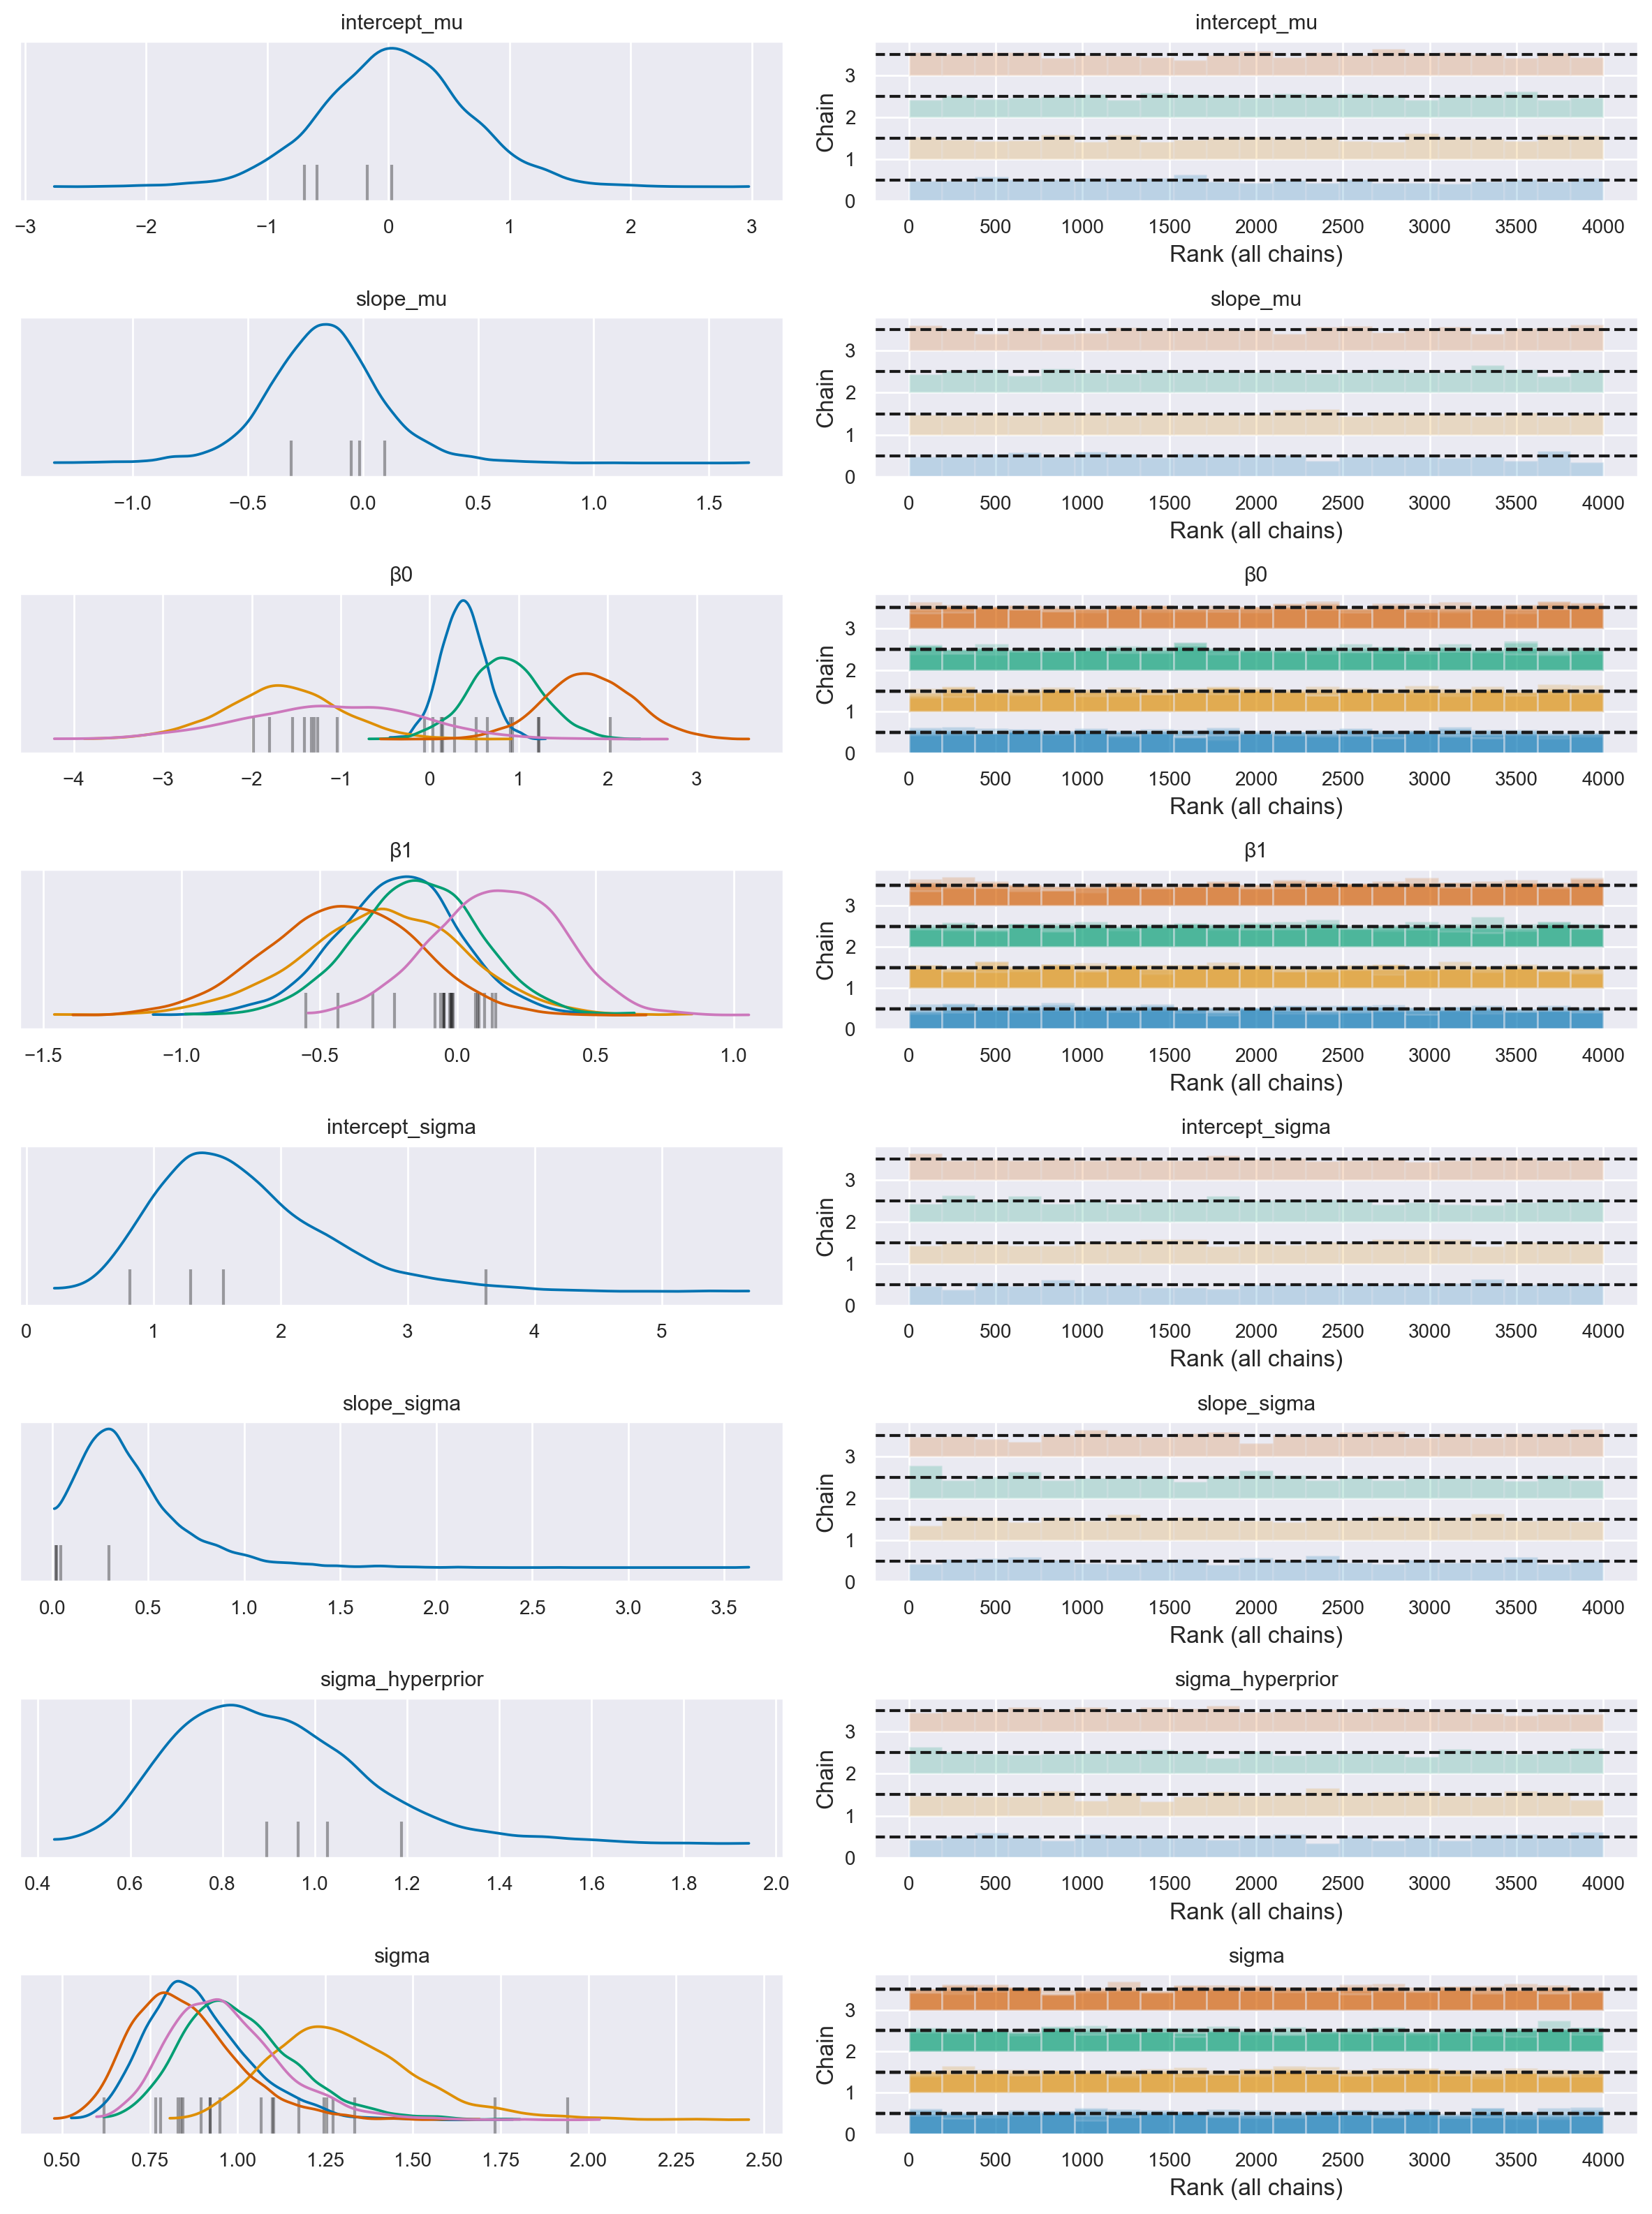

In [28]:
az.plot_trace(
    idata,
    combined=True,
    filter_vars="regex",
    var_names=["~μ"],
    kind="rank_bars",
    divergences="bottom",
)
plt.tight_layout()

In [29]:
non_centered = True

with pm.Model(coords=coords) as hierarchical:
    # Hyperpriors
    intercept_mu = pm.Normal("intercept_mu", 0, sigma=1)
    intercept_sigma = pm.HalfNormal("intercept_sigma", sigma=2)
    slope_mu = pm.Normal("slope_mu", 0, sigma=1)
    slope_sigma = pm.HalfNormal("slope_sigma", sigma=2)
    sigma_hyperprior = pm.HalfNormal("sigma_hyperprior", sigma=0.5)

    # Define priors
    sigma = pm.HalfNormal("sigma", sigma=sigma_hyperprior, dims="group")

    if non_centered:
        β0_offset = pm.Normal("β0_offset", 0, sigma=1, dims="group")
        β0 = pm.Deterministic("β0", intercept_mu + β0_offset * intercept_sigma, dims="group")
        β1_offset = pm.Normal("β1_offset", 0, sigma=1, dims="group")
        β1 = pm.Deterministic("β1", slope_mu + β1_offset * slope_sigma, dims="group")
    else:
        β0 = pm.Normal("β0", intercept_mu, sigma=intercept_sigma, dims="group")
        β1 = pm.Normal("β1", slope_mu, sigma=slope_sigma, dims="group")

    # Data
    x = pm.MutableData("x", data.x, dims="obs_id")
    g = pm.MutableData("g", data.group_idx, dims="obs_id")
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="obs_id")

In [30]:
with hierarchical:
    idata = pm.sampling_jax.sample_numpyro_nuts(tune=5000, target_accept=0.99)

Compiling...


Compilation time = 0:00:01.494932


Sampling...


  0%|                                                                                  | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/6000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/6000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/6000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/6000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/6000 [00:03<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/6000 [00:03<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/6000 [00:03<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/6000 [00:03<?, ?it/s]

Running chain 0:   5%|██▋                                                   | 300/6000 [00:03<00:05, 984.53it/s]

Running chain 1:   5%|██▋                                                   | 300/6000 [00:03<00:05, 951.05it/s]

Running chain 3:   5%|██▋                                                   | 300/6000 [00:03<00:06, 940.66it/s]

Running chain 2:   5%|██▋                                                   | 300/6000 [00:03<00:06, 881.26it/s]

Running chain 3:  10%|█████▎                                               | 600/6000 [00:04<00:04, 1241.30it/s]

Running chain 0:  10%|█████▎                                               | 600/6000 [00:04<00:04, 1218.61it/s]

Running chain 1:  10%|█████▎                                               | 600/6000 [00:04<00:04, 1206.80it/s]

Running chain 2:  10%|█████▎                                               | 600/6000 [00:04<00:04, 1175.81it/s]

Running chain 1:  15%|███████▉                                             | 900/6000 [00:04<00:03, 1364.77it/s]

Running chain 3:  15%|███████▉                                             | 900/6000 [00:04<00:03, 1340.45it/s]

Running chain 0:  15%|███████▉                                             | 900/6000 [00:04<00:04, 1272.60it/s]

Running chain 2:  15%|███████▉                                             | 900/6000 [00:04<00:03, 1311.96it/s]

Running chain 1:  20%|██████████▍                                         | 1200/6000 [00:04<00:03, 1411.07it/s]

Running chain 2:  20%|██████████▍                                         | 1200/6000 [00:04<00:03, 1414.07it/s]

Running chain 0:  20%|██████████▍                                         | 1200/6000 [00:04<00:03, 1325.09it/s]

Running chain 3:  20%|██████████▍                                         | 1200/6000 [00:04<00:03, 1301.35it/s]

Running chain 1:  25%|█████████████                                       | 1500/6000 [00:04<00:03, 1418.48it/s]

Running chain 2:  25%|█████████████                                       | 1500/6000 [00:04<00:03, 1416.38it/s]

Running chain 3:  25%|█████████████                                       | 1500/6000 [00:04<00:03, 1324.74it/s]

Running chain 0:  25%|█████████████                                       | 1500/6000 [00:04<00:03, 1316.36it/s]

Running chain 1:  30%|███████████████▌                                    | 1800/6000 [00:04<00:02, 1471.52it/s]

Running chain 2:  30%|███████████████▌                                    | 1800/6000 [00:04<00:03, 1358.92it/s]

Running chain 0:  30%|███████████████▌                                    | 1800/6000 [00:04<00:03, 1323.97it/s]

Running chain 3:  30%|███████████████▌                                    | 1800/6000 [00:04<00:03, 1270.19it/s]

Running chain 1:  35%|██████████████████▏                                 | 2100/6000 [00:05<00:02, 1466.41it/s]

Running chain 2:  35%|██████████████████▏                                 | 2100/6000 [00:05<00:02, 1379.92it/s]

Running chain 0:  35%|██████████████████▏                                 | 2100/6000 [00:05<00:02, 1356.13it/s]

Running chain 3:  35%|██████████████████▏                                 | 2100/6000 [00:05<00:02, 1317.13it/s]

Running chain 1:  40%|████████████████████▊                               | 2400/6000 [00:05<00:02, 1511.80it/s]

Running chain 2:  40%|████████████████████▊                               | 2400/6000 [00:05<00:02, 1362.58it/s]

Running chain 0:  40%|████████████████████▊                               | 2400/6000 [00:05<00:02, 1341.41it/s]

Running chain 3:  40%|████████████████████▊                               | 2400/6000 [00:05<00:02, 1305.07it/s]

Running chain 1:  45%|███████████████████████▍                            | 2700/6000 [00:05<00:02, 1541.78it/s]

Running chain 2:  45%|███████████████████████▍                            | 2700/6000 [00:05<00:02, 1420.67it/s]

Running chain 0:  45%|███████████████████████▍                            | 2700/6000 [00:05<00:02, 1326.71it/s]

Running chain 3:  45%|███████████████████████▍                            | 2700/6000 [00:05<00:02, 1353.97it/s]

Running chain 1:  50%|██████████████████████████                          | 3000/6000 [00:05<00:01, 1505.53it/s]

Running chain 2:  50%|██████████████████████████                          | 3000/6000 [00:05<00:02, 1425.76it/s]

Running chain 0:  50%|██████████████████████████                          | 3000/6000 [00:05<00:02, 1381.82it/s]

Running chain 3:  50%|██████████████████████████                          | 3000/6000 [00:05<00:02, 1385.74it/s]

Running chain 1:  55%|████████████████████████████▌                       | 3300/6000 [00:05<00:01, 1497.63it/s]

Running chain 2:  55%|████████████████████████████▌                       | 3300/6000 [00:05<00:01, 1436.71it/s]

Running chain 1:  60%|███████████████████████████████▏                    | 3600/6000 [00:05<00:01, 1551.42it/s]

Running chain 0:  55%|████████████████████████████▌                       | 3300/6000 [00:06<00:01, 1388.87it/s]

Running chain 3:  55%|████████████████████████████▌                       | 3300/6000 [00:06<00:01, 1363.78it/s]

Running chain 2:  60%|███████████████████████████████▏                    | 3600/6000 [00:06<00:01, 1430.44it/s]

Running chain 1:  65%|█████████████████████████████████▊                  | 3900/6000 [00:06<00:01, 1545.23it/s]

Running chain 0:  60%|███████████████████████████████▏                    | 3600/6000 [00:06<00:01, 1431.40it/s]

Running chain 3:  60%|███████████████████████████████▏                    | 3600/6000 [00:06<00:01, 1426.98it/s]

Running chain 2:  65%|█████████████████████████████████▊                  | 3900/6000 [00:06<00:01, 1455.88it/s]

Running chain 0:  65%|█████████████████████████████████▊                  | 3900/6000 [00:06<00:01, 1431.98it/s]

Running chain 1:  70%|████████████████████████████████████▍               | 4200/6000 [00:06<00:01, 1420.34it/s]

Running chain 3:  65%|█████████████████████████████████▊                  | 3900/6000 [00:06<00:01, 1396.37it/s]

Running chain 2:  70%|████████████████████████████████████▍               | 4200/6000 [00:06<00:01, 1445.21it/s]

Running chain 0:  70%|████████████████████████████████████▍               | 4200/6000 [00:06<00:01, 1410.75it/s]

Running chain 1:  75%|███████████████████████████████████████             | 4500/6000 [00:06<00:01, 1448.35it/s]

Running chain 3:  70%|████████████████████████████████████▍               | 4200/6000 [00:06<00:01, 1386.85it/s]

Running chain 2:  75%|███████████████████████████████████████             | 4500/6000 [00:06<00:01, 1474.47it/s]

Running chain 1:  80%|█████████████████████████████████████████▌          | 4800/6000 [00:06<00:00, 1476.40it/s]

Running chain 0:  75%|███████████████████████████████████████             | 4500/6000 [00:06<00:01, 1394.66it/s]

Running chain 3:  75%|███████████████████████████████████████             | 4500/6000 [00:06<00:01, 1368.22it/s]

Running chain 2:  80%|█████████████████████████████████████████▌          | 4800/6000 [00:06<00:00, 1458.79it/s]

Running chain 0:  80%|█████████████████████████████████████████▌          | 4800/6000 [00:07<00:00, 1419.56it/s]

Running chain 1:  85%|████████████████████████████████████████████▏       | 5100/6000 [00:07<00:00, 1429.93it/s]

Running chain 3:  80%|█████████████████████████████████████████▌          | 4800/6000 [00:07<00:00, 1369.56it/s]

Running chain 2:  85%|████████████████████████████████████████████▏       | 5100/6000 [00:07<00:00, 1434.71it/s]

Running chain 0:  85%|████████████████████████████████████████████▏       | 5100/6000 [00:07<00:00, 1458.87it/s]

Running chain 1:  90%|██████████████████████████████████████████████▊     | 5400/6000 [00:07<00:00, 1369.66it/s]

Running chain 3:  85%|████████████████████████████████████████████▏       | 5100/6000 [00:07<00:00, 1399.40it/s]

Running chain 2:  90%|██████████████████████████████████████████████▊     | 5400/6000 [00:07<00:00, 1435.31it/s]

Running chain 0:  90%|██████████████████████████████████████████████▊     | 5400/6000 [00:07<00:00, 1524.05it/s]

Running chain 3:  90%|██████████████████████████████████████████████▊     | 5400/6000 [00:07<00:00, 1477.23it/s]

Running chain 1:  95%|█████████████████████████████████████████████████▍  | 5700/6000 [00:07<00:00, 1332.56it/s]

Running chain 0:  95%|█████████████████████████████████████████████████▍  | 5700/6000 [00:07<00:00, 1573.75it/s]

Running chain 2:  95%|█████████████████████████████████████████████████▍  | 5700/6000 [00:07<00:00, 1417.87it/s]

Running chain 3:  95%|█████████████████████████████████████████████████▍  | 5700/6000 [00:07<00:00, 1535.18it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 6000/6000 [00:07<00:00, 1602.63it/s]

Running chain 1: 100%|████████████████████████████████████████████████████| 6000/6000 [00:07<00:00, 1294.33it/s]

Running chain 2: 100%|████████████████████████████████████████████████████| 6000/6000 [00:07<00:00, 1436.03it/s]

Running chain 3: 100%|████████████████████████████████████████████████████| 6000/6000 [00:07<00:00, 1562.65it/s]

Running chain 0: 100%|█████████████████████████████████████████████████████| 6000/6000 [00:07<00:00, 764.62it/s]


Running chain 1: 100%|█████████████████████████████████████████████████████| 6000/6000 [00:07<00:00, 764.74it/s]


Running chain 2: 100%|█████████████████████████████████████████████████████| 6000/6000 [00:07<00:00, 764.89it/s]


Running chain 3: 100%|█████████████████████████████████████████████████████| 6000/6000 [00:07<00:00, 765.03it/s]

Sampling time = 0:00:08.034354


Transforming variables...


Transformation time = 0:00:00.189316


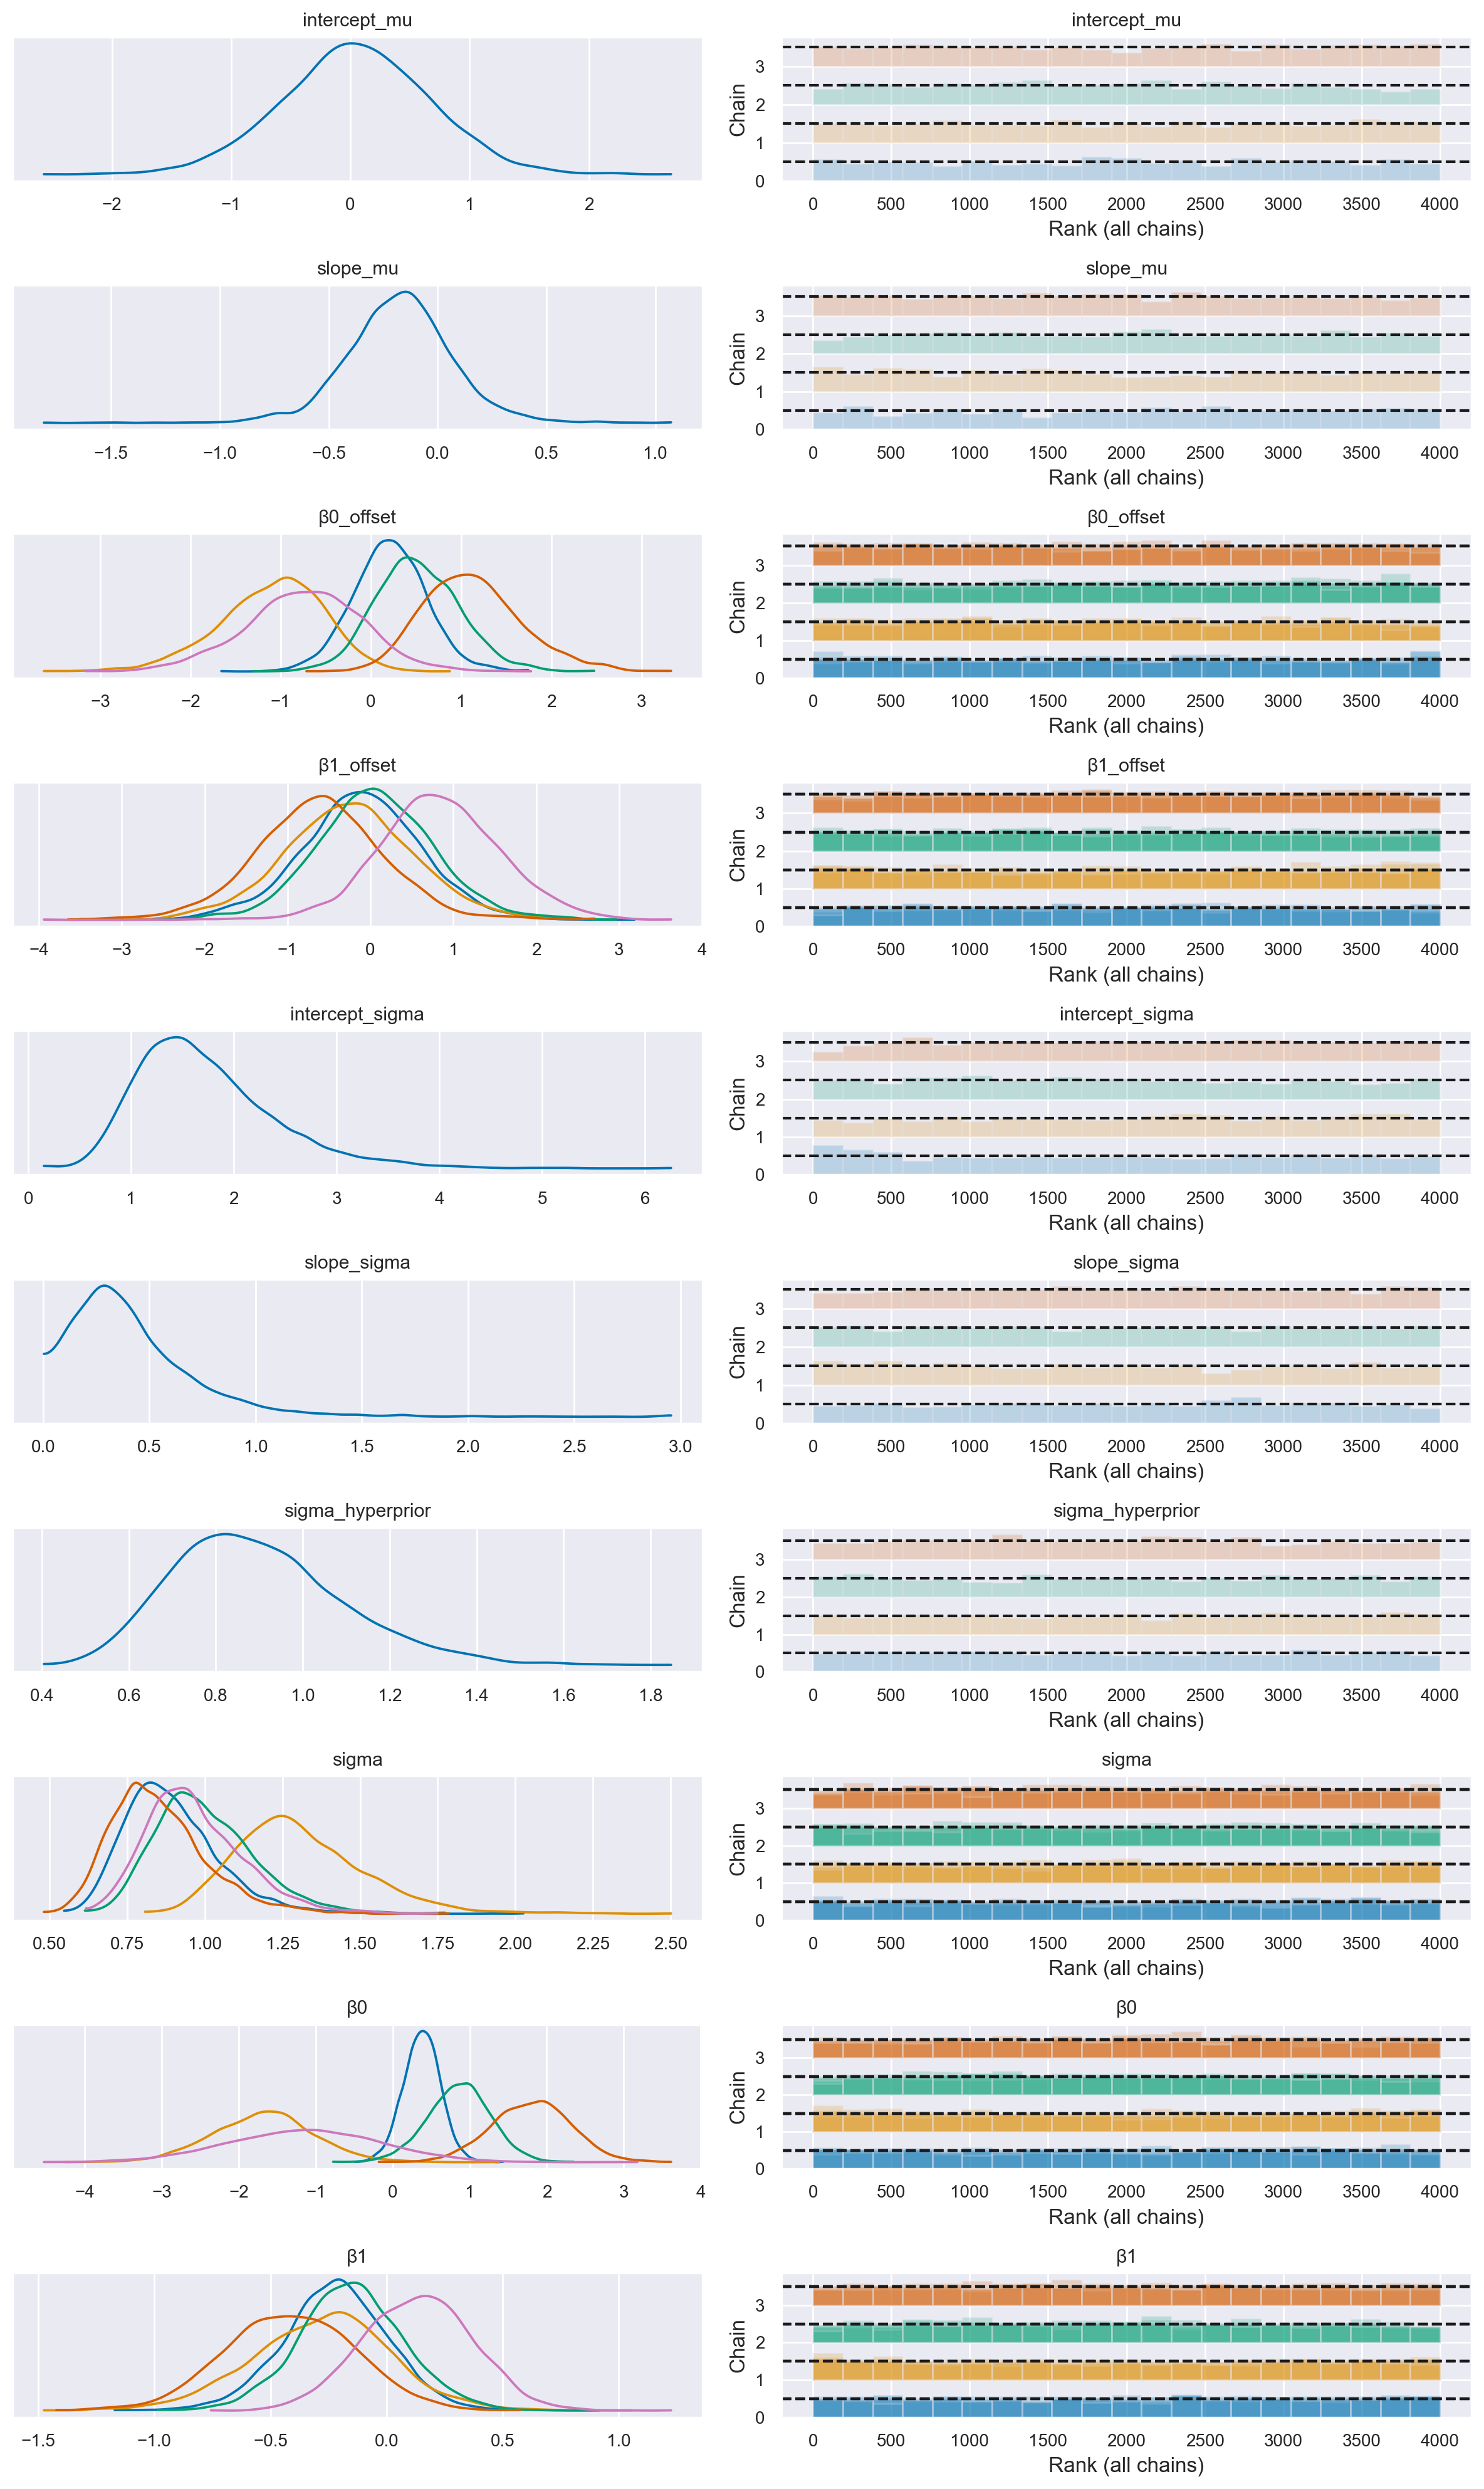

In [31]:
az.plot_trace(
    idata,
    combined=True,
    filter_vars="regex",
    var_names=["~μ"],
    kind="rank_bars",
    divergences="bottom",
)
plt.tight_layout()

In [32]:
# Create values of x and g to use for posterior prediction
xi = [
    np.linspace(data.query(f"group_idx=={i}").x.min(), data.query(f"group_idx=={i}").x.max(), 10)
    for i, _ in enumerate(group_list)
]
g = [np.ones(10) * i for i, _ in enumerate(group_list)]
xi, g = np.concatenate(xi), np.concatenate(g)

# Do the posterior prediction
with hierarchical:
    pm.set_data({"x": xi, "g": g.astype(int)})
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["μ", "y"]))

Sampling: [y]


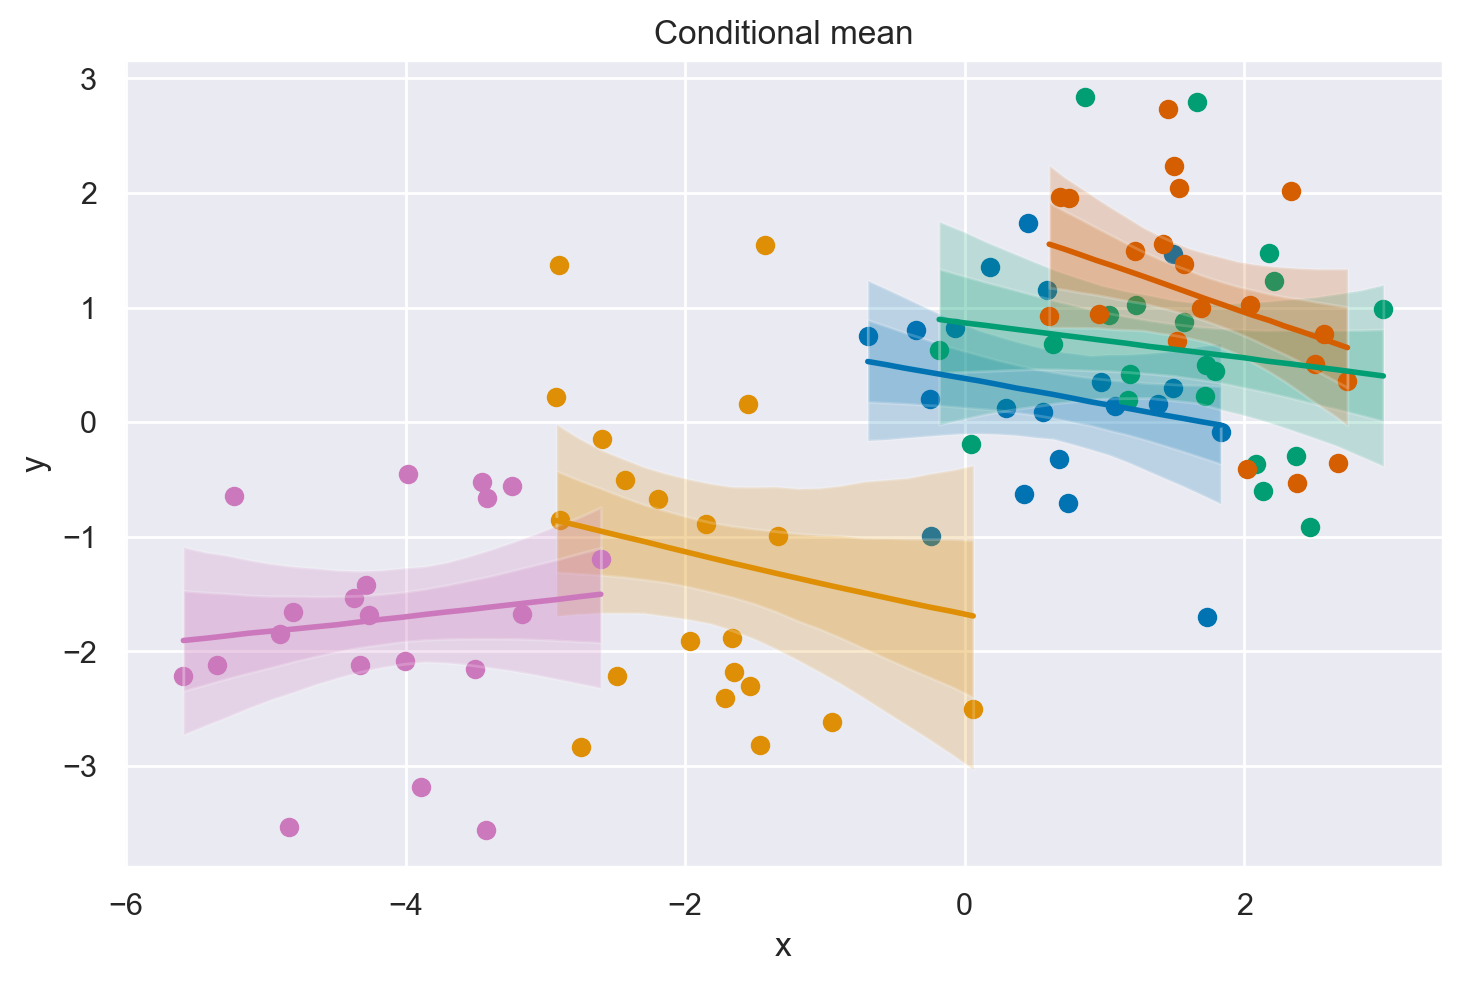

In [33]:
fig, ax = plt.subplots(1, 1)

# conditional mean plot ---------------------------------------------
for i, groupname in enumerate(group_list):
    # data
    ax.scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
    # conditional mean credible intervals
    post = az.extract(idata)
    _xi = xr.DataArray(
        np.linspace(np.min(data.x[data.group_idx == i]), np.max(data.x[data.group_idx == i]), 20),
        dims=["x_plot"],
    )
    y = post.β0.sel(group=groupname) + post.β1.sel(group=groupname) * _xi
    region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
    ax.fill_between(
        _xi,
        region.sel(quantile=0.025),
        region.sel(quantile=0.975),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    ax.fill_between(
        _xi,
        region.sel(quantile=0.15),
        region.sel(quantile=0.85),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    # conditional mean
    ax.plot(_xi, region.sel(quantile=0.5), color=f"C{i}", linewidth=2)
    # formatting
    ax.set(xlabel="x", ylabel="y", title="Conditional mean")


In [34]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

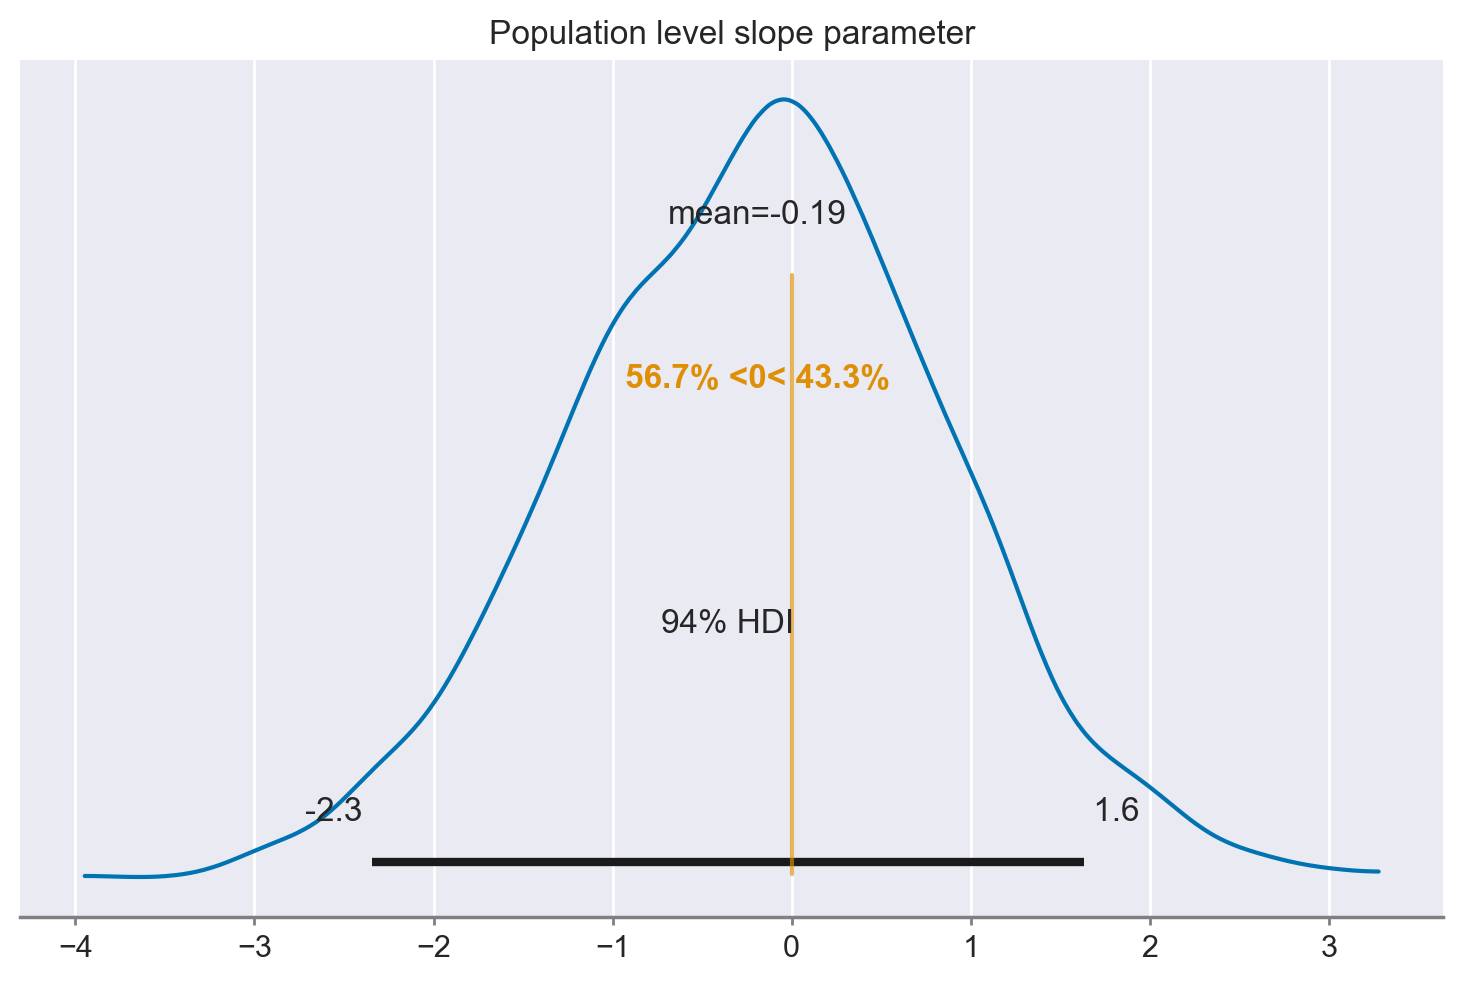

In [35]:
# plot posterior for population level slope
slope = rng.normal(az.extract(idata.posterior, var_names="slope_mu"))
az.plot_posterior(slope, ref_val=0)
_ = plt.title("Population level slope parameter")

In [36]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Jan 26 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

numpy     : 1.26.2
seaborn   : 0.13.0
xarray    : 2023.12.0
matplotlib: 3.8.2
scipy     : 1.11.4
pandas    : 2.1.4
pymc      : 5.10.3
arviz     : 0.17.0

Watermark: 2.4.3

